loading the Api


In [156]:
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from googleapiclient.discovery import build

load_dotenv("api.env")
api_key = os.getenv("YOUTUBE_API_KEY")

## Fetching for comments and loading it to csv file

In [157]:
# Initialize API connection
youtube = build("youtube", "v3", developerKey=api_key)

def get_comments(video_id, max_comments=500):
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            textFormat="plainText",
            order="relevance", # i used order relveance to get comments with higher likes
            pageToken=next_page_token
        ).execute()

        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]
            comments.append({
                "author": comment["authorDisplayName"],
                "text": comment["textDisplay"],
                "likeCount": comment["likeCount"],
                "publishedAt": comment["publishedAt"]
            })

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return pd.DataFrame(comments)


video_id = "ko70cExuzZM"  # i used a music video to test with 
df = get_comments(video_id, max_comments=500)
print(df.head())
df.to_csv("comments.csv", index=False)


            author                                               text  \
0      @kaelidance  I am in AWE of how they built the sets and all...   
1  @Mywonderland13  She’s the definition of “every color suits me”...   
2   @BlairCall-c4l  I love how she used her Eras team!! The dancer...   
3  @hypnotic-knock  This may be her best song yet.  The lyrics.  T...   
4      @SwifTea013  this might be her best mv yet, the visuals, th...   

   likeCount           publishedAt  
0      41813  2025-10-05T23:06:43Z  
1      41648  2025-10-05T22:57:35Z  
2      67270  2025-10-05T23:06:40Z  
3        125  2025-11-08T00:24:59Z  
4      59457  2025-10-05T23:05:15Z  


## Getting Sentiment with the use of TextBlob 

In [158]:
def get_sentiment(text):
    blob=TextBlob(text)
    polarity=blob.sentiment.polarity
    if polarity>0:
        return "positive"
    elif polarity<0:
        return "negative"
    else:
        return "neutral"
df["Sentiments"]=df["text"].apply(get_sentiment)
print(df["Sentiments"])
df.to_csv("youtube_comments_with_sentiment_by_TextBlob.csv",index=False)

0       neutral
1      positive
2      positive
3      positive
4      positive
         ...   
495     neutral
496    positive
497    positive
498    negative
499    positive
Name: Sentiments, Length: 500, dtype: object


## Distribution of the Sentiment 

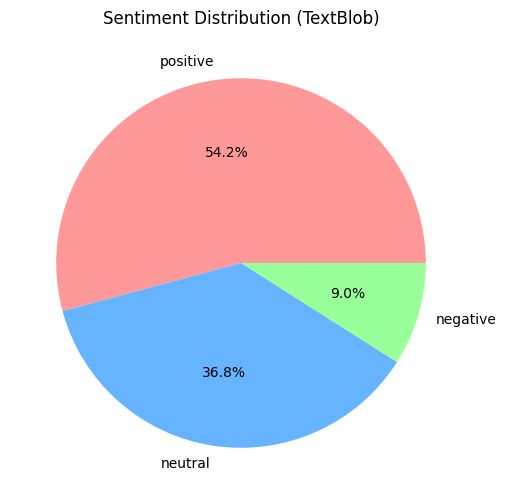

In [159]:
plt.figure(figsize=(10, 6))
sentiment_counts = df["Sentiments"].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']  # red, blue, green
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Sentiment Distribution (TextBlob)')
plt.show()

## Training a Logistic Regression model

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

spliting the data into 80% training and 20% to testing


In [161]:
X=df["text"]
y=df["Sentiments"]
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=11)

tokenzation

In [162]:
vectorizer=TfidfVectorizer(stop_words='english')
X_train_tfidf=vectorizer.fit_transform(X_train)
X_test_tfdif=vectorizer.transform(X_test)

In [163]:
model=LogisticRegression()
model.fit(X_train_tfidf,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Report of Logistic Regression

In [164]:
y_pred=model.predict(X_test_tfdif)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.66

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.08      0.14        13
     neutral       0.67      0.44      0.53        36
    positive       0.65      0.96      0.78        51

    accuracy                           0.66       100
   macro avg       0.77      0.49      0.48       100
weighted avg       0.70      0.66      0.61       100



## Using nltk vader

In [165]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer=SentimentIntensityAnalyzer()

df1=pd.read_csv('comments.csv')

In [166]:
def vader_scores(text):
    if not isinstance(text,str):
        text=""
    return analyzer.polarity_scores(text)
df1=pd.read_csv("comments.csv")
vader_df=df1["text"].apply(vader_scores).apply(pd.Series)
df1=pd.concat([df1.reset_index(drop=True),vader_df.reset_index(drop=True)],axis=1)



In [167]:
def state_Sentiment(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

df1["Sentiment_vader"]=df1['compound'].apply(state_Sentiment)
df1["Sentiment_vader"]
df1.to_csv('youtube_comment_sentiment_with_vader.csv',index=False)


## Predecting 

In [168]:
from sklearn.metrics import confusion_matrix
y_true = df['Sentiments']
y_pred = df1['Sentiment_vader']
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

    

Accuracy: 0.748

Classification Report:
               precision    recall  f1-score   support

    negative       0.48      0.47      0.47        45
     neutral       0.80      0.60      0.69       184
    positive       0.76      0.90      0.82       271

    accuracy                           0.75       500
   macro avg       0.68      0.65      0.66       500
weighted avg       0.75      0.75      0.74       500


Confusion Matrix:
 [[ 21   6  18]
 [ 16 110  58]
 [  7  21 243]]


## Charts

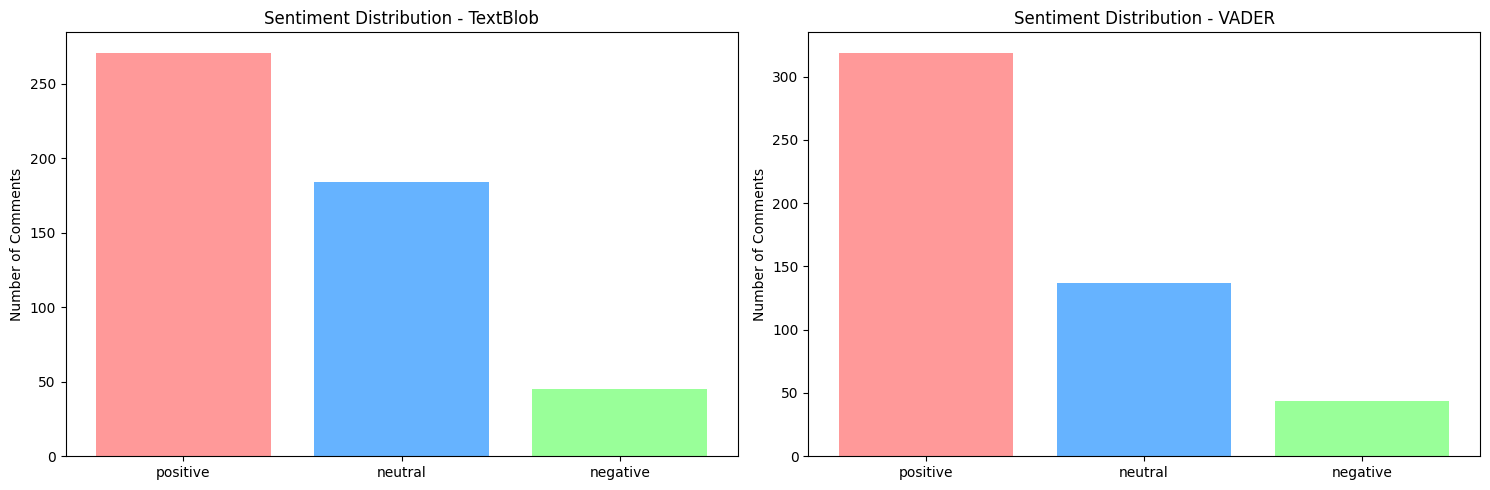

In [169]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# TextBlob
tb_counts = df["Sentiments"].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
ax1.bar(tb_counts.index, tb_counts.values, color=colors)
ax1.set_title('Sentiment Distribution - TextBlob')
ax1.set_ylabel('Number of Comments')

# VADER
vader_counts = df1["Sentiment_vader"].value_counts()
ax2.bar(vader_counts.index, vader_counts.values, color=colors)
ax2.set_title('Sentiment Distribution - VADER')
ax2.set_ylabel('Number of Comments')

plt.tight_layout()
plt.show()

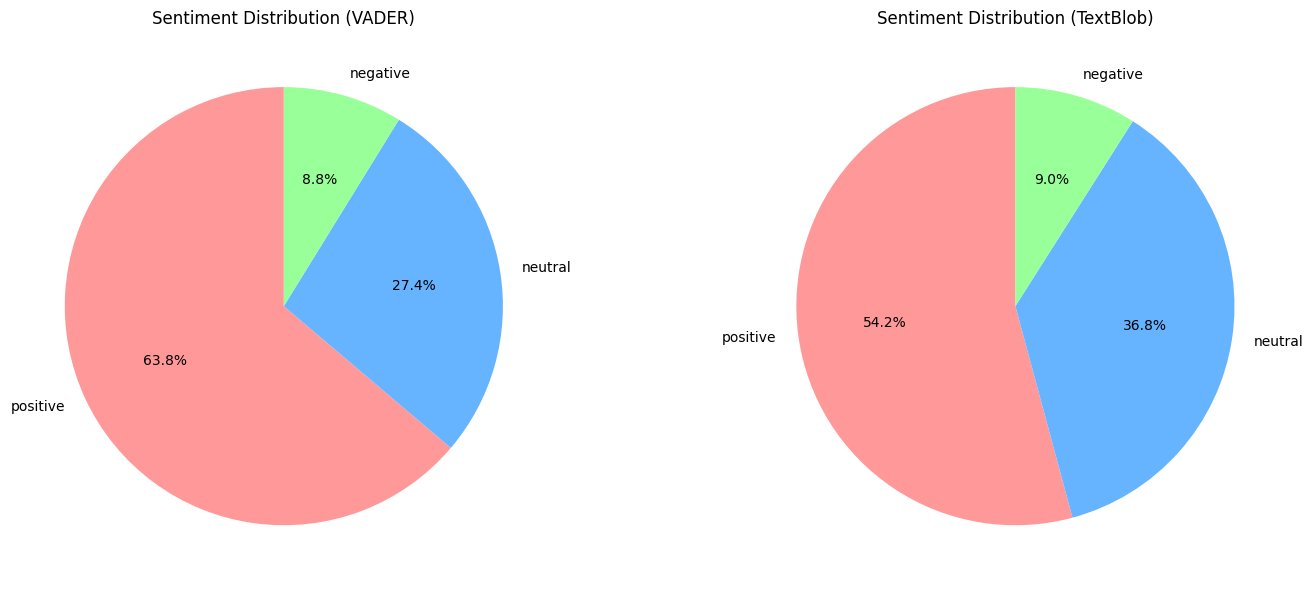

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# VADER Pie Chart
sentiment_counts_vader = df1["Sentiment_vader"].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']  
ax1.pie(sentiment_counts_vader.values, labels=sentiment_counts_vader.index, 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Sentiment Distribution (VADER)')

# TextBlob Pie Chart
sentiment_counts_textblob = df["Sentiments"].value_counts()
ax2.pie(sentiment_counts_textblob.values, labels=sentiment_counts_textblob.index, 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Sentiment Distribution (TextBlob)')

plt.tight_layout()
plt.show()